In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow.keras.models import load_model
import tensorflow as tf
import arviz as az
import matplotlib.pyplot as plt

2023-01-11 08:14:53.650812: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-11 08:14:53.816415: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import meq

In [4]:
def prev_curves(params, eir):
    p = meq.default_parameters()
    (
        p.kb,
        #p.ub,
        p.b0,
        p.b1,
        p.IB0
    ) = params
    p.EIR = eir
    solution = meq.solve(p)
    prop = np.array(solution.prop, dtype=np.float32)
    pos_M = np.array(solution.pos_M, dtype=np.float32)
    inc = np.array(solution.pos_M, dtype=np.float32)
    return np.array([
        pos_M[3:10].sum() / prop[3:10].sum(),
        pos_M[10:].sum() / prop[10:].sum(),
        inc[:5].sum() / prop[:5].sum(),
        inc[5:15].sum() / prop[5:15].sum(),
        inc[15:].sum() / prop[15:].sum()
    ])

In [5]:
kb = np.random.lognormal(0., 1.)
#ub = np.random.lognormal(1., 1.)
b0 = np.random.beta(2., 1.)
b1 = np.random.beta(1., 2.)
IB0 = np.random.gamma(40., 1.)

In [6]:
kb, b0, b1, IB0

(1.4612324106460488, 0.6642629604985835, 0.606046832952487, 43.702324504858815)

In [7]:
population = 100_000
EIR = 21.

In [8]:
observations = prev_curves([kb, b0, b1, IB0], EIR) * population

In [9]:
observations

array([59251.90448761, 30137.15445995, 52289.60514069, 55470.16859055,
       24901.68660879])

In [10]:
def model_prev(kb, b0, b1, IB0, eir):
    if len(b0.shape) == 0:
        return []
    return np.stack(
        [prev_curves([kb[i], b0[i], b1[i], IB0[i]], eir) for i in range(b0.shape[0])]
    )

def prob_prev(*args):
    prev_pred = model_prev(*args)
    return tfd.Independent(
        tfd.Binomial(total_count=population, probs=prev_pred, validate_args=True),
        reinterpreted_batch_ndims=1
    )

In [11]:
prob_prev(tf.constant([kb]), tf.constant([b0]), tf.constant([b1]), tf.constant([IB0]), tf.constant(EIR))#.log_prob(observed_prev)

2023-01-11 08:14:55.722323: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-11 08:14:56.648754: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37095 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:27:00.0, compute capability: 8.0
2023-01-11 08:14:56.650570: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 37815 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:28:00.0, compute capability: 8.0


<tfp.distributions.Independent 'IndependentBinomial' batch_shape=[1] event_shape=[5] dtype=float32>

In [12]:
model_prev(tf.constant([kb]), tf.constant([b0]), tf.constant([b1]), tf.constant([IB0]), tf.constant(EIR))

array([[0.59251904, 0.30137154, 0.52289605, 0.5547017 , 0.24901687]],
      dtype=float32)

In [13]:
from collections import OrderedDict

joint_dist = tfp.distributions.JointDistributionNamed(
    OrderedDict(
        kb = tfd.LogNormal(0., 1., validate_args=True), #kb = tfd.Gamma(4., 1., validate_args=True),
        #ub = tfd.Uniform(0., 100., validate_args=True), #ub = tfd.LogNormal(1., 1., validate_args=True),
        b0 = tfd.Beta(2., 1., validate_args=True), #b0 = tfd.Beta(7., 1., validate_args=True),
        b1 = tfd.Beta(1., 2., validate_args=True),
        IB0 = tfd.TruncatedCauchy(50., 20., 0., 100.),#IB0 = tfd.Gamma(40., 1., validate_args=True),
        prev = lambda kb, b0, b1, IB0: prob_prev(kb, b0, b1, IB0, tf.constant(EIR))
    )
)

In [14]:
*prior_samples, prior_predictive = joint_dist.sample(1000).values()

In [15]:
num_chains = 10

observed_prev = tf.constant(np.round(observations), dtype=tf.float32)
pinned_joint_dist = joint_dist.experimental_pin(prev = observed_prev)
initial_state_dict = pinned_joint_dist.sample_unpinned(num_chains)
initial_state = list(initial_state_dict.values())
parameter_names = pinned_joint_dist._flat_resolve_names()

In [16]:
%%time

# Initialize the HMC transition kernel.
tf.config.experimental.enable_tensor_float_32_execution(False)
num_results = 1000 #int(1e3)
num_burnin_steps = 1000 #100 #int(1e3)

# initial_step_size = [
#     tf.constant(1e-1, shape=[num_chains] + [1] * (len(x.shape) - 1))
#     for x in initial_state
# ]

def log_prob(*state):
    return pinned_joint_dist.unnormalized_log_prob(state)

# mcmc = tfp.mcmc.TransformedTransitionKernel(
#     tfp.mcmc.SimpleStepSizeAdaptation(
#         inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
#             target_log_prob_fn=log_prob,
#             num_leapfrog_steps=50,
#             step_size=initial_step_size
#         ),
#         num_adaptation_steps=int(num_burnin_steps * 0.8)#int(num_burnin_steps * 0.8)
#     ),
#     pinned_joint_dist.experimental_default_event_space_bijector().bijectors
# )

mcmc = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=log_prob,
        new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=.04)
    ),
    pinned_joint_dist.experimental_default_event_space_bijector().bijectors
)

# Add a progress bar
pbar = tfp.experimental.mcmc.ProgressBarReducer(num_results + num_burnin_steps)
mcmc = tfp.experimental.mcmc.WithReductions(mcmc, pbar)

def run_chain():
    return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      parallel_iterations=num_chains,
      kernel=mcmc,
      trace_fn=lambda _, pkr: pkr.inner_results.inner_results.is_accepted
    )

samples, acceptance = run_chain()

100%|████████████████████████████████████▉| 1999/2000 [02:23<00:00, 12.26it/s]

CPU times: user 2min 36s, sys: 3.92 s, total: 2min 40s
Wall time: 2min 24s


In [17]:
acceptance.numpy().mean()

0.4955

In [18]:
parameter_names = pinned_joint_dist._flat_resolve_names()

In [19]:
posterior_predictive = tf.concat([
    list(joint_dist.sample(value=dict(zip(parameter_names, [s[:,chain,...] for s in samples]))).values())[-1][tf.newaxis, ..., tf.newaxis]
    for chain in range(num_chains)
], 0)

In [20]:
trace = az.from_dict(
    prior={k: v[tf.newaxis, ...] for k, v in zip(parameter_names, prior_samples)},
    posterior={
        k: np.swapaxes(v, 0, 1) for k, v in zip(parameter_names, samples)
    },
    prior_predictive={"observations": prior_predictive[tf.newaxis, ..., tf.newaxis]},
    posterior_predictive={"observations": posterior_predictive},
    coords={"observation": np.arange(5), "param": np.arange(len(parameter_names))},
    observed_data={"observations": observations},
    dims={"observations": ["observation"], "coefficients": ["param"]},
)

print(trace)

Inference data with groups:
	> posterior
	> posterior_predictive
	> prior
	> prior_predictive
	> observed_data


In [21]:
print(az.summary(trace).filter(items=["mean", "hdi_3%", "hdi_97%", "ess_mean", "ess_bulk", "r_hat"]))

       mean  hdi_3%  hdi_97%  ess_bulk  r_hat
kb    0.859   0.170    2.468      11.0   2.98
b0    0.778   0.645    0.933      11.0   3.07
b1    0.388   0.088    0.622      12.0   2.79
IB0  55.619  24.640   84.675      11.0   3.08


In [22]:
kb, b0, b1, IB0

(1.4612324106460488, 0.6642629604985835, 0.606046832952487, 43.702324504858815)

100%|████████████████████████████████████▉| 1999/2000 [02:40<00:00, 12.26it/s]

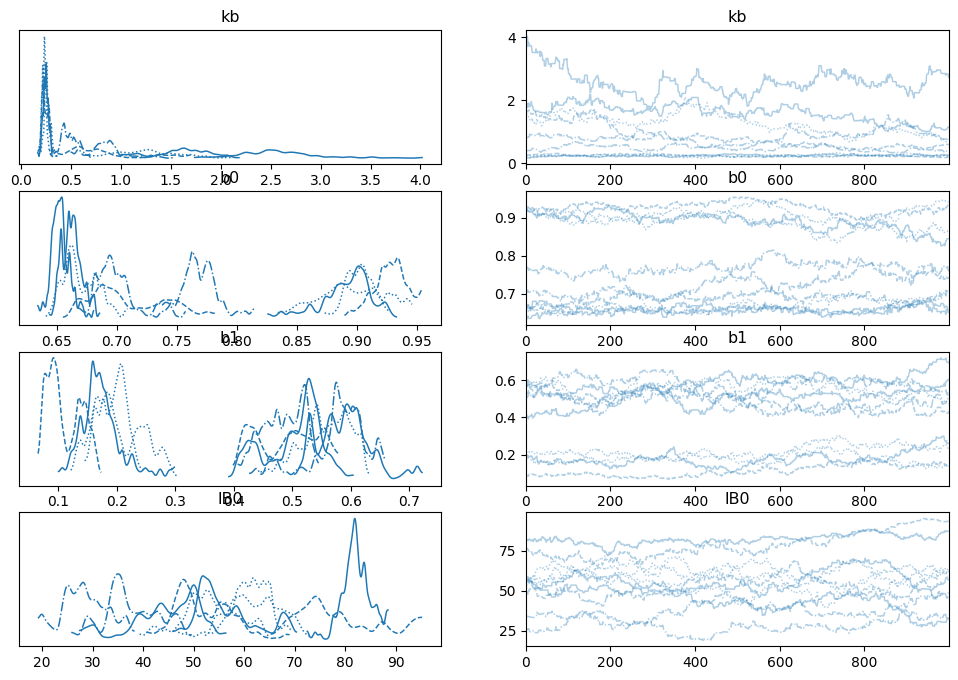

In [23]:
axs = az.plot_trace(trace, var_names=['kb', 'b0', 'b1', 'IB0'])

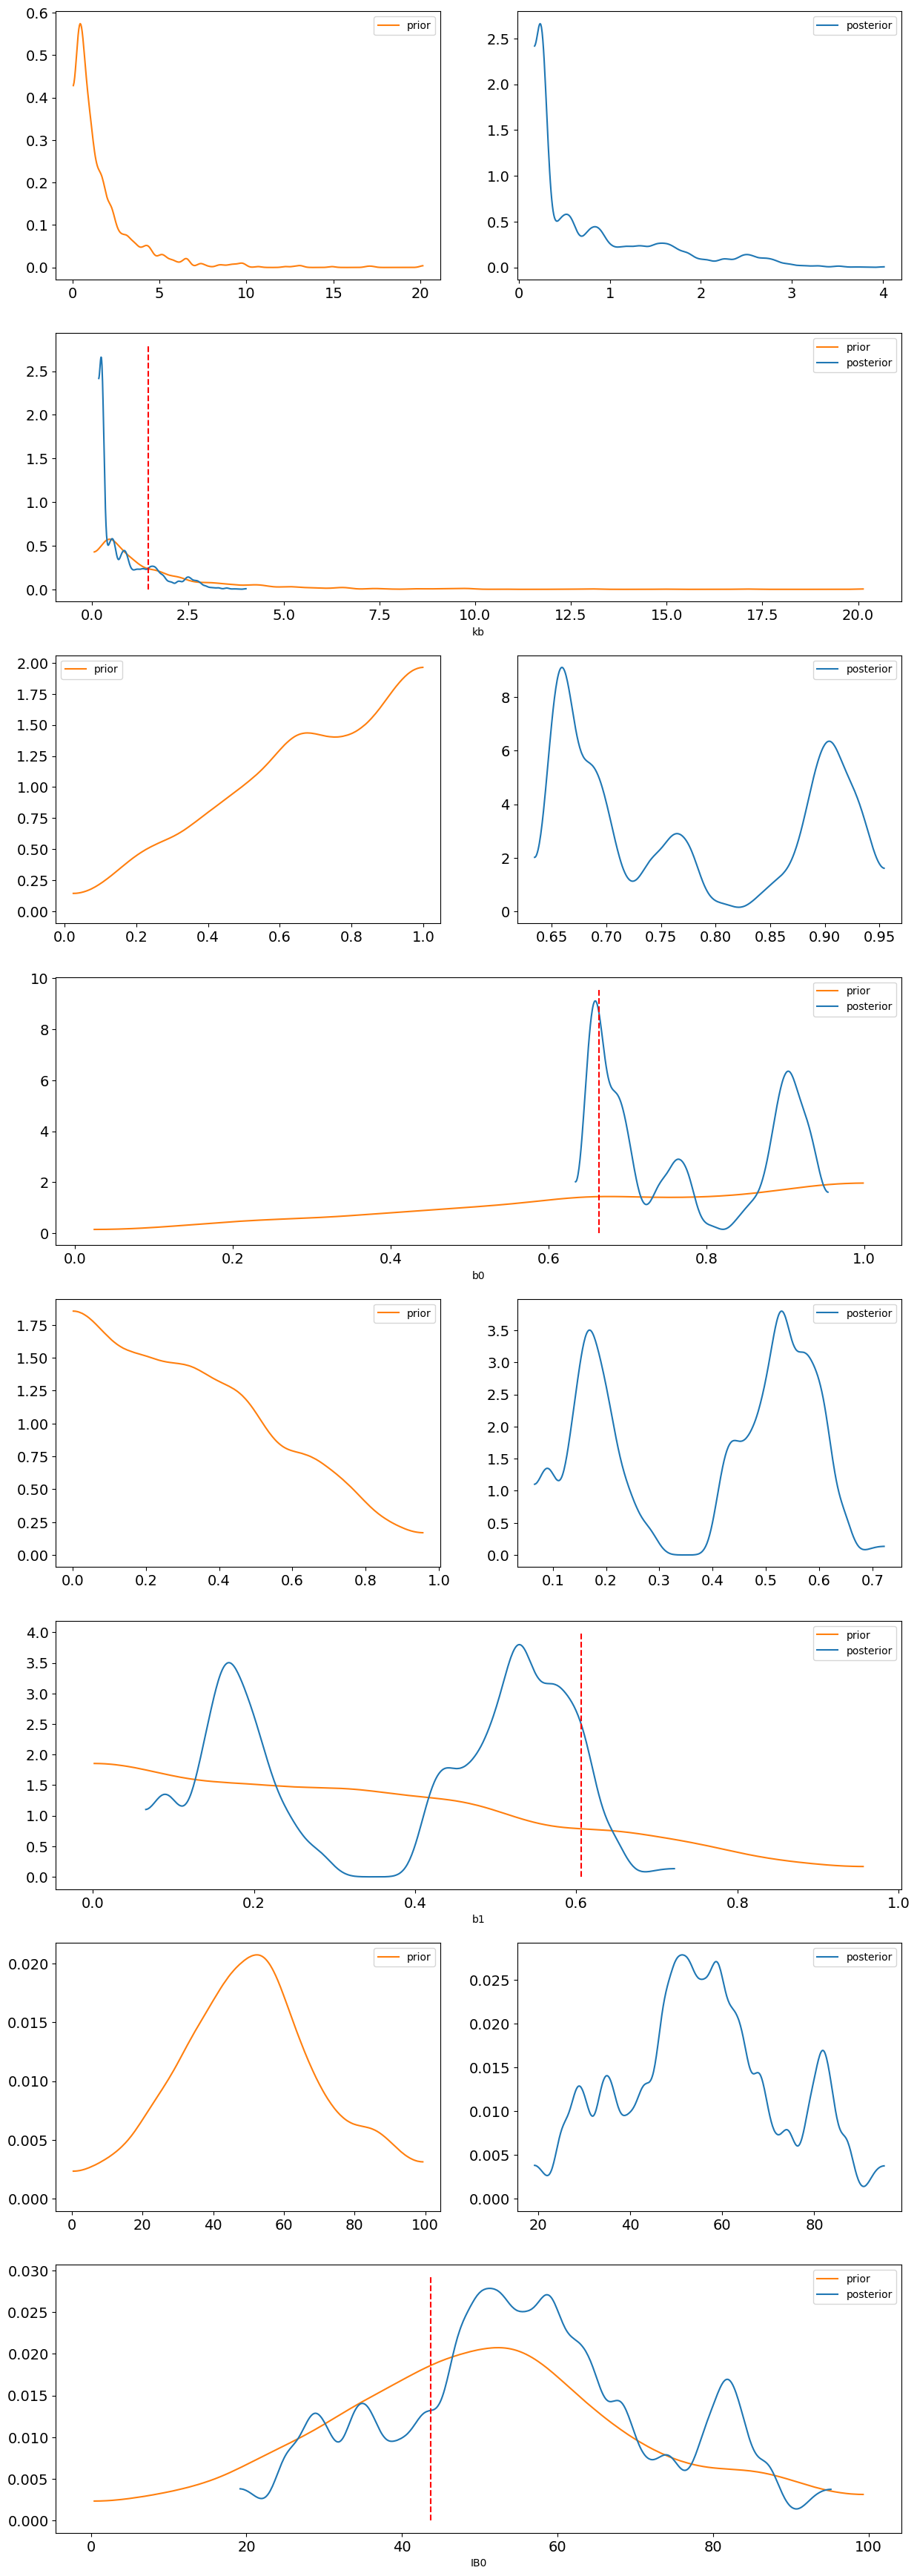

In [24]:
axs = az.plot_dist_comparison(trace)
for i in range(axs.shape[0]):
    axs[i, 2].vlines(
        [kb, b0, b1, IB0][i],
        0,
        axs[i, 2].get_ylim()[1],
        color = 'red',
        linestyle = 'dashed'
    )